# Training an Image Classifier
1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [50]:
from IPython.display import Image

CIFAR-10 
small colored pictures. 3X32x32pix with. 10 classes. using 3 channel color images of 32x32pix


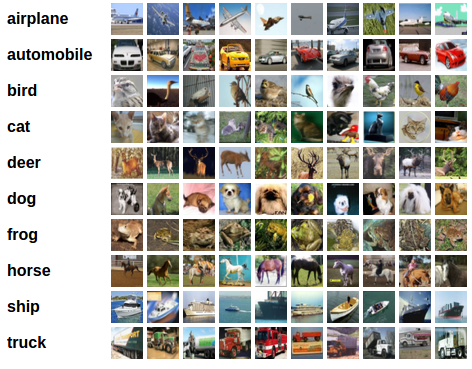

### 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

u = standard deviation = .5

input = input-u/standard deviation

input = input - .5/.5

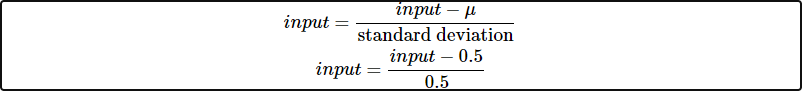

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
#the computer will not understand the picture and even if it does get inputted it will take a long time to train hence not efficient.
#process of making efficient will be normalization 

transform = transforms.Compose(
    #tensor = matrix / array
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


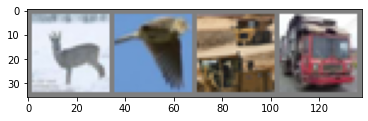

 deer  bird truck truck
torch.Size([4, 3, 32, 32])


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#4 batchsize and 3 color channel 32x32 image
print(images.shape) 

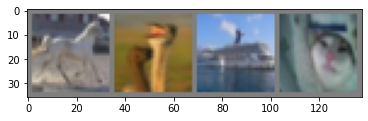

horse  bird  ship   cat


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Convolutional Neural Network CNN

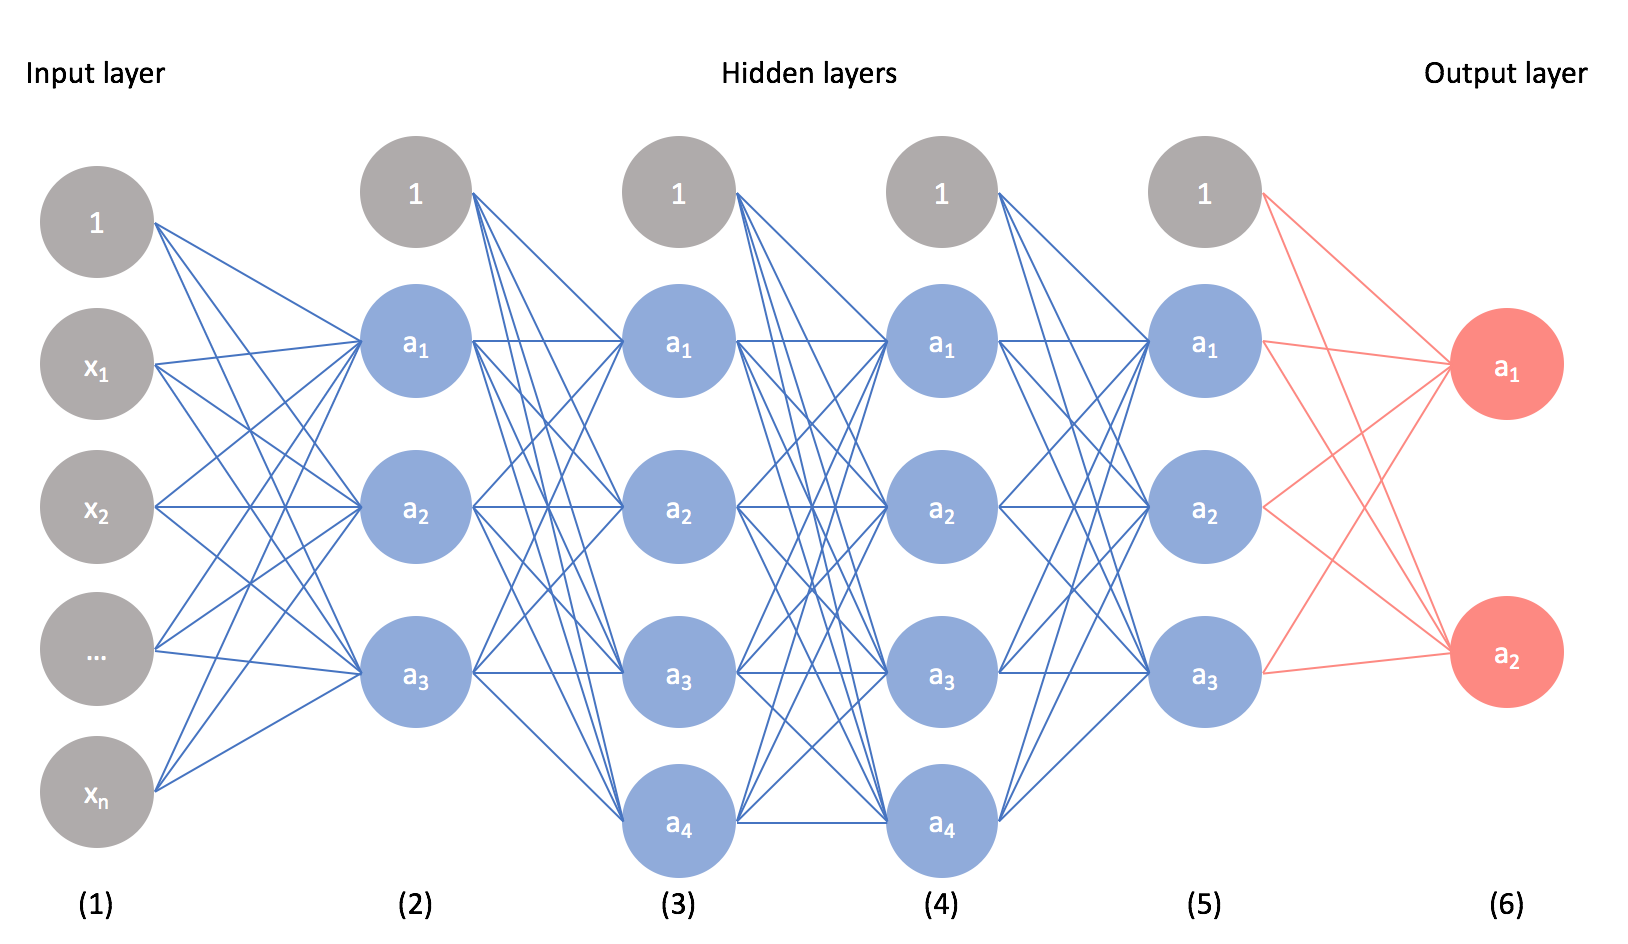

Filters 3x3 will detect patterns. Patterns will be shape edge texture etc. Circle, Square, Corners (Geometric filter). Deeper in layer will be able to detect specific objects like eyes, hairs, feathers, wheels. More deeper it will detect cat, Dog, Cars etc.

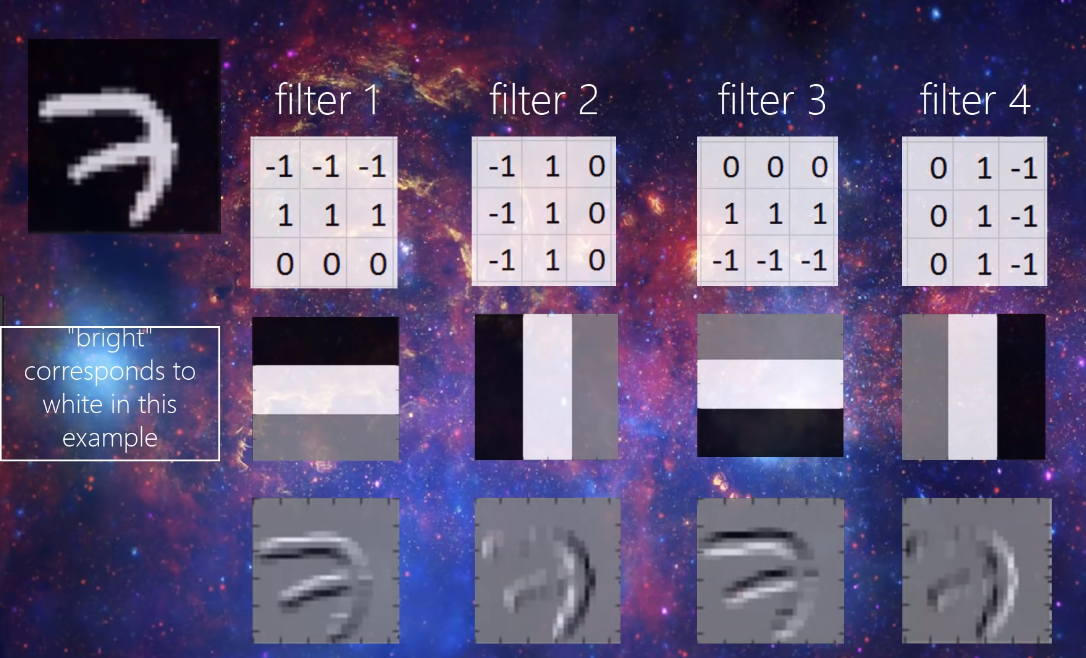

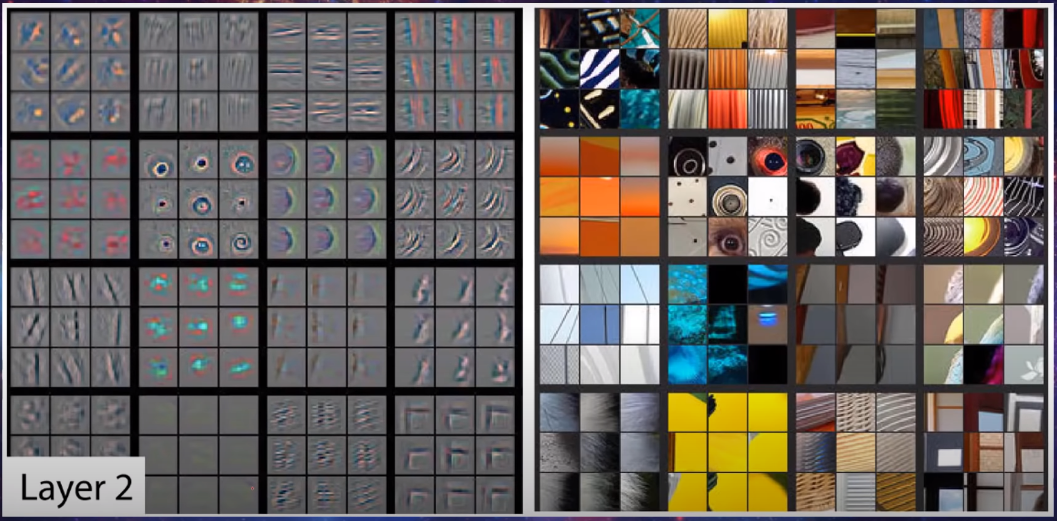

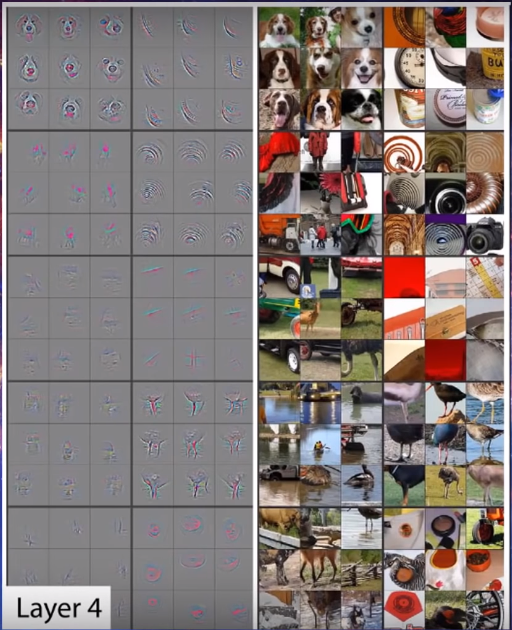

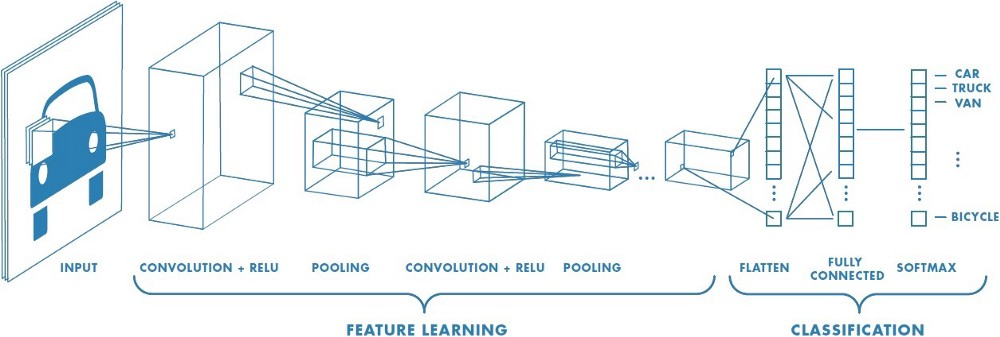

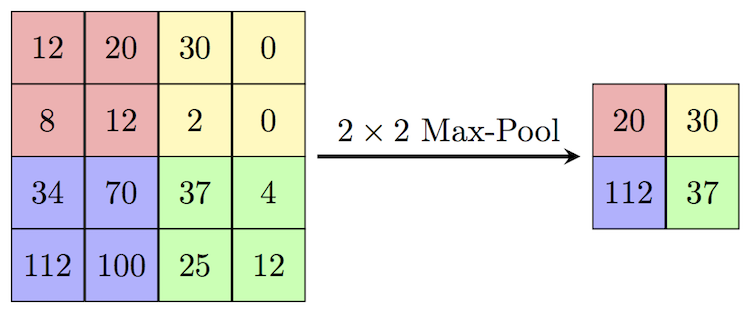


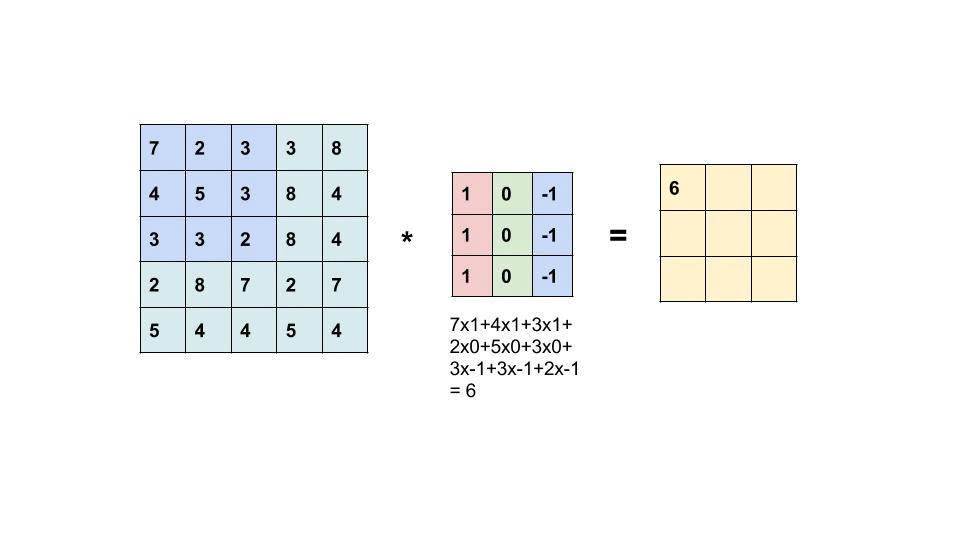


output size may be different because they do not fit perfectly in the corners

Input width, Filter size, Padding, Stride
 
#### (W-F + 2P)/S + 1

5x5input, 3x3 filter, padding = 0, stride = 1

(5-3 + 0)/1 + 1 = 
2/1 + 1 = 3
 -> 3x3


In [33]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #nn.Conv2d(input channel size, output channel size, kernel size(filter size))
        self.conv1 = nn.Conv2d(3, 6, 5)
        #kernal size is 2x2 and we go right by 2 so stride is 2
        self.pool = nn.MaxPool2d(2, 2)
        #input channel size must be last output size
        self.conv2 = nn.Conv2d(6, 16, 5)
        #16 * 5 * 5 fixed value
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #120 input feature and 84 output feature
        self.fc2 = nn.Linear(120, 84)
        #input size and 10 output size (10 class) fixed value
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #first conv pooling layer 
        x = self.pool(F.relu(self.conv1(x)))
        #second conv pooling layer
        x = self.pool(F.relu(self.conv2(x)))
        #first fully connected layer (Flatten) in tensor to resize use view()
        x = x.view(-1, 16 * 5 * 5)
        #first fully connected with relu activation
        x = F.relu(self.fc1(x))
        #second fully connected with relu activation
        x = F.relu(self.fc2(x))
        #last fully connected 
        #No softMax function because it is added in the Loss function
        x = self.fc3(x)
        return x


net = Net()

In [49]:
conv1 =  nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
print(images.shape)
c = conv1(images)
print(c.shape)
c = pool(c)
print(c.shape)
c = conv2(c)
print(c.shape)
c = pool(c)
print(c.shape)

#After the convolution layer and in to classification layer we want to flatten 3D to 1D tensor so the input size of the linear layer is 16*5*5

torch.Size([4, 3, 32, 32])
torch.Size([4, 6, 28, 28])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 10, 10])
torch.Size([4, 16, 5, 5])


### 3. Define a Loss function and optimizer

In [6]:
#loss and optimizer.  
#multi-class clasification so use CrossEntropyLoss
#optimizer use stochastic gradient descent (SGD) which optimize the net parameters (needs to be adjusted and tuned to match) with defined learning rate (lr)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [9]:
#loop over the number of epoch
#Epochs. One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. 
#Since one epoch is too big to feed to the computer at once we divide it in several smaller batches.

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    #loop over the trainloader to get all the batches
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #simply Data is fine since we are just using CPU but in the future for more heavy load use 
        #labels =labels.to(device) for GPU support
        inputs, labels = data

        # zero the parameter gradients
        # emptying the gradient
        optimizer.zero_grad()

        # forward + backward + optimize
        # forward pass to get lost
        #pred_y = model(x_data)
        outputs = net(inputs)
        #how different true value and output is. prediction vs real
        #loss = criterion(pred_y, y_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics information
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.142
[1,  4000] loss: 1.823
[1,  6000] loss: 1.657
[1,  8000] loss: 1.548
[1, 10000] loss: 1.515
[1, 12000] loss: 1.467
[2,  2000] loss: 1.384
[2,  4000] loss: 1.383
[2,  6000] loss: 1.348
[2,  8000] loss: 1.305
[2, 10000] loss: 1.313
[2, 12000] loss: 1.279
Finished Training


In [10]:
#save trained model for future use
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

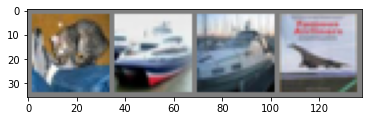

GroundTruth:    cat  ship  ship plane


In [11]:
#We have trained the network for 2 passes over trainning dataset. Let's test if the network learnt anything. 
#We will varify by predicting the class label that the neural network outputs, then check with the ground truth.
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
#loading the saved model. * we did not have to re-load the model because we never exited but this is just an illustration
net = Net()
net.load_state_dict(torch.load(PATH))

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 77 %
Accuracy of   car : 62 %
Accuracy of  bird : 29 %
Accuracy of   cat : 25 %
Accuracy of  deer : 51 %
Accuracy of   dog : 54 %
Accuracy of  frog : 57 %
Accuracy of horse : 70 %
Accuracy of  ship : 64 %
Accuracy of truck : 36 %


In [22]:
#Check how the network performs on the whole dataset
correct = 0
total = 0

class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

#wrapping up
#calculate the accuracy of the total network 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(4):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                class_correct[label]+=1
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [23]:
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print('Accuracy of the %s: %d %%' % (classes[i], acc))

Accuracy of the plane: 77 %
Accuracy of the car: 62 %
Accuracy of the bird: 29 %
Accuracy of the cat: 25 %
Accuracy of the deer: 51 %
Accuracy of the dog: 54 %
Accuracy of the frog: 57 %
Accuracy of the horse: 70 %
Accuracy of the ship: 64 %
Accuracy of the truck: 36 %


### Training on GPU

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [25]:
# device is CUDA device (GPU)
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
inputs, labels = data[0].to(device), data[1].to(device)